In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

from absl import flags

In [2]:
## Relative imports
from dataHandler.dataset import MHDProjDataset,LogNormalTransform

from ddpm.model import UNet, ResUNet
from ddpm.diffusion import DDPM, generate_image, NCSN

from validationMetrics.powerSpectrum import power_spectrum_iso, plot_ps
from validationMetrics.minkowskiFunctional import plot_mink_functionals

from utils.scheduler import WarmUp

In [3]:
from scipy.signal import savgol_filter

In [4]:
import torch.nn as nn

In [5]:
MODEL_ID = 'MHD_DDPM_skip_GN_bottleneck32_diffusion10000_beta1e-4_dens'
SOURCE_DIR = '/mnt/home/dheurtel/ceph/00_exploration_data/density/b_proj'

SAMPLE_FOLDER = '/mnt/home/dheurtel/ceph/20_samples/artificial_architecture_exps'  #For periodic samples
CKPT_FOLDER = '/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps' #For checkpoints and losses


SIZE = 256

N_STEPS = 1000
BATCH_SIZE = 64
SAMPLE_BATCH_SIZE = 8
RESULT_SAMPLE_SIZE = 256



SAVE_STEP_EPOCH = 200
SAMPLE_STEP_EPOCH = 200

NUM_EPOCHS = 2000
LR = 1e-3

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
FLAGS=flags.FLAGS
try:
    flags.DEFINE_string('model_id','MHD_DDPM_forget',help= 'ID of the model either trained, finetuned, evaluated....')

    ## Data & transforms
    flags.DEFINE_string('source_dir','/mnt/home/dheurtel/ceph/00_exploration_data/density/b_proj',help= 'Source dir containing a list of npy files')
    flags.DEFINE_bool('random_rotate', True, help='')
    flags.DEFINE_bool('no_lognorm', False, help='apply a lognormal transformation to the dataset')

    ## Network & diffusion parameters

    flags.DEFINE_enum('diffusion_mode', 'ddpm', ['ddpm', 'smld', 'VE', 'VD', 'sub_VP'], help='Type of diffusion SDE used during training and inference')
    ## TODO if we want to fully use the SDE/ score based framework (and have custom/off the shelf SDE solvers, we will nedd to use runners/differentiate the training loop)
    # For DDPM
    flags.DEFINE_integer('n_steps', 1000, help= 'Diffusion total time see Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')
    flags.DEFINE_float('beta_start', 1e-4, help = 'Beta at time 0 see Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')
    flags.DEFINE_float('beta_T',0.02, help= 'Beta at time T=n_steps Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')

    #Unet
    flags.DEFINE_enum('network', 'unet', ['unet', 'ResUNet'], help='DUNet not yet implemented')
    flags.DEFINE_integer('size',256, help='height and width of the images')
    flags.DEFINE_integer('in_channel', 1, help= 'number of channel on input and output images')
    flags.DEFINE_enum('normalization', 'LN' , ['LN' , 'default', 'LN-D', 'LN-F', 'LN-F+', 'LN-DF', 'BN', 'BN/LN', 'BN/FLN', 'BN/F+LN', 'DBN/LN', 'GN', 'DN','None'], help= 'type of normalization applied') ## TODO upcoming cleaning of these options based on elimination and perceived redundancies
    flags.DEFINE_float('eps_norm', 1e-5, help= 'epsilon value added to the variance in the normalization layer to ensure numerical stability')
    flags.DEFINE_integer('size_min', 32, help= 'size at the bottleneck')
    flags.DEFINE_integer('num_blocks', 1, help= 'num of blocks per size on descent')
    flags.DEFINE_enum('padding_mode', 'circular' ,['zeros', 'reflect', 'replicate','circular'], help='Conv2d padding mode')
    flags.DEFINE_bool('muP', False, help= 'Use mu Parametrisation for initialisation and training') ## TODO 
    flags.DEFINE_float('dropout', 0, help= 'Probability for dropout, we did not find any impact because our models tend not to overfit')
    flags.DEFINE_integer('first_c_mult', 10, help= 'Multiplier between in_c and out_c for the first block')
    flags.DEFINE_bool('skip_rescale', False, help='Rescale skip connections (see Score Based Generative Modelling paper)')

    ## Training parameters 
    flags.DEFINE_integer('batch_size', 64, help='Dataloader batch size')
    flags.DEFINE_integer('num_sample', 8, help='Number of sample for an epoch in the middle')
    flags.DEFINE_integer('num_result_sample', 256, help='Number of sample for an epoch in the middle')
    flags.DEFINE_float('lr', 1e-3, help= 'Learning rate')
    flags.DEFINE_enum('lr_scheduler', 'None', ['None','stepLR'], help='scheduler, if any used in training')
    flags.DEFINE_integer('warmup', 100, help='Length of warmup, if 0 then no warmup')
    flags.DEFINE_integer('test_set_len', 95, help='')
    flags.DEFINE_integer('num_epochs', 500, help='Number of epochs')
    flags.DEFINE_enum('optimizer', 'Adam', ['AdamW', 'Adam', 'MoMo'], help='MoMo not implemented in particular for now') ## TODO MoMo 
    flags.DEFINE_float('weight_decay', 0.0, help= 'Weight decay hyper parameter')
    flags.DEFINE_float('ema', 0.0, help='Exponentially moving average momentum, if 0 then no ema applied NOT IMPLEMENTED yet ')  ## TODO

    ## Sampling and checkpointing
    flags.DEFINE_integer('save_step_epoch', 100, help='Period in nb of epochs for saving ckpt & losses')
    flags.DEFINE_integer('sample_step_epoch', 100, help='Period in nb of epoch for generating a few npy samples')
    flags.DEFINE_string('sample_folder','/mnt/home/dheurtel/ceph/20_samples/artificial_architecture_exps',help= 'directory where generated samples (in the middle of training) or results are stored')
    flags.DEFINE_string('ckpt_folder','/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps',help= 'Directory for ckpt & loss storage (as well as some training specs)')


except:
    print("Flags already defined but you can still re-parse them with next few cells")

In [8]:
def extract_flag_name(str):
    pref='--'
    suff='='
    try:
        idx1 = str.index(pref)
        idx2 = str.index(suff)
    except:
        try:
            idx1 = str.index(pref)
            idx2=len(str)
        except:
            return None
    return str[idx1 + len(pref): idx2]

In [9]:
with open(os.path.join(CKPT_FOLDER, MODEL_ID, 'flagfile.txt')) as f:
    lines = f.read().splitlines()

lines=[s for s in lines if extract_flag_name(s) in FLAGS]

FLAGS(lines)

['--batch_size=64']

In [10]:
dataset=MHDProjDataset(SOURCE_DIR,random_rotate=True,transforms=LogNormalTransform(),test_batch_length=95)

dataloader = DataLoader(dataset=dataset, batch_size=256, shuffle=True, num_workers=8)

In [11]:
if FLAGS.network == "unet":
        log2sizes = list(
            range(int(np.log2(FLAGS.size_min)), int(np.log2(FLAGS.size)) + 1)
        )[::-1]
        sizes = [2**i for i in log2sizes]

        network = UNet(
            in_c=FLAGS.in_channel,
            out_c=FLAGS.in_channel,
            first_c=FLAGS.first_c_mult * FLAGS.in_channel,
            sizes=sizes,
            num_blocks=1,
            n_steps=FLAGS.n_steps,
            time_emb_dim=100,
            dropout=FLAGS.dropout,
            attention=[],
            normalisation=FLAGS.normalization,
            padding_mode=FLAGS.padding_mode,
            eps_norm=FLAGS.eps_norm,
        )
        network = network.to(device)
if FLAGS.network == "ResUNet":
    log2sizes = list(
        range(int(np.log2(FLAGS.size_min)), int(np.log2(FLAGS.size)) + 1)
    )[::-1]
    sizes = [2**i for i in log2sizes]

    network = ResUNet(
        in_c=FLAGS.in_channel,
        out_c=FLAGS.in_channel,
        first_c=FLAGS.first_c_mult * FLAGS.in_channel,
        sizes=sizes,
        num_blocks=1,
        n_steps=FLAGS.n_steps,
        time_emb_dim=100,
        dropout=FLAGS.dropout,
        attention=[],
        normalisation=FLAGS.normalization,
        padding_mode=FLAGS.padding_mode,
        eps_norm=FLAGS.eps_norm,
        skiprescale=FLAGS.skip_rescale,
    )
    network = network.to(device)

if FLAGS.diffusion_mode == "ddpm":
    model = DDPM(
        network,
        FLAGS.n_steps,
        beta_start=FLAGS.beta_start,
        beta_end=FLAGS.beta_T,
        device=device,
    )
elif FLAGS.diffusion_mode == "smld":
    model = NCSN(
        network,
        FLAGS.n_steps,
        beta_start=FLAGS.beta_start,
        beta_end=FLAGS.beta_T,
        device=device,
        )

In [12]:
ckpt = torch.load(os.path.join(CKPT_FOLDER, MODEL_ID, 'ckpt.pt'),map_location=torch.device('cpu'))
file_list=ckpt['test_set']
np.random.shuffle(file_list)
model.load_state_dict(ckpt['ddpm_model'])

<All keys matched successfully>

In [13]:
batch_enumerate=enumerate(dataloader)

In [14]:
_,batch=next(batch_enumerate)
batch=batch.unsqueeze(1)
test_batch=LogNormalTransform()(torch.cat([torch.from_numpy(np.load(os.path.join(SOURCE_DIR,filename))).unsqueeze(0).unsqueeze(0) for filename in file_list]))
test_batch.shape,batch.shape

(torch.Size([95, 1, 256, 256]), torch.Size([256, 1, 256, 256]))

In [15]:
amin,amax=(-6.232629, 7.390278)

In [16]:
im=test_batch[:16]
superposition=im+torch.randn(im.shape)
superposition=superposition.to(device)
superposition_2=im+torch.roll(im,1,0)

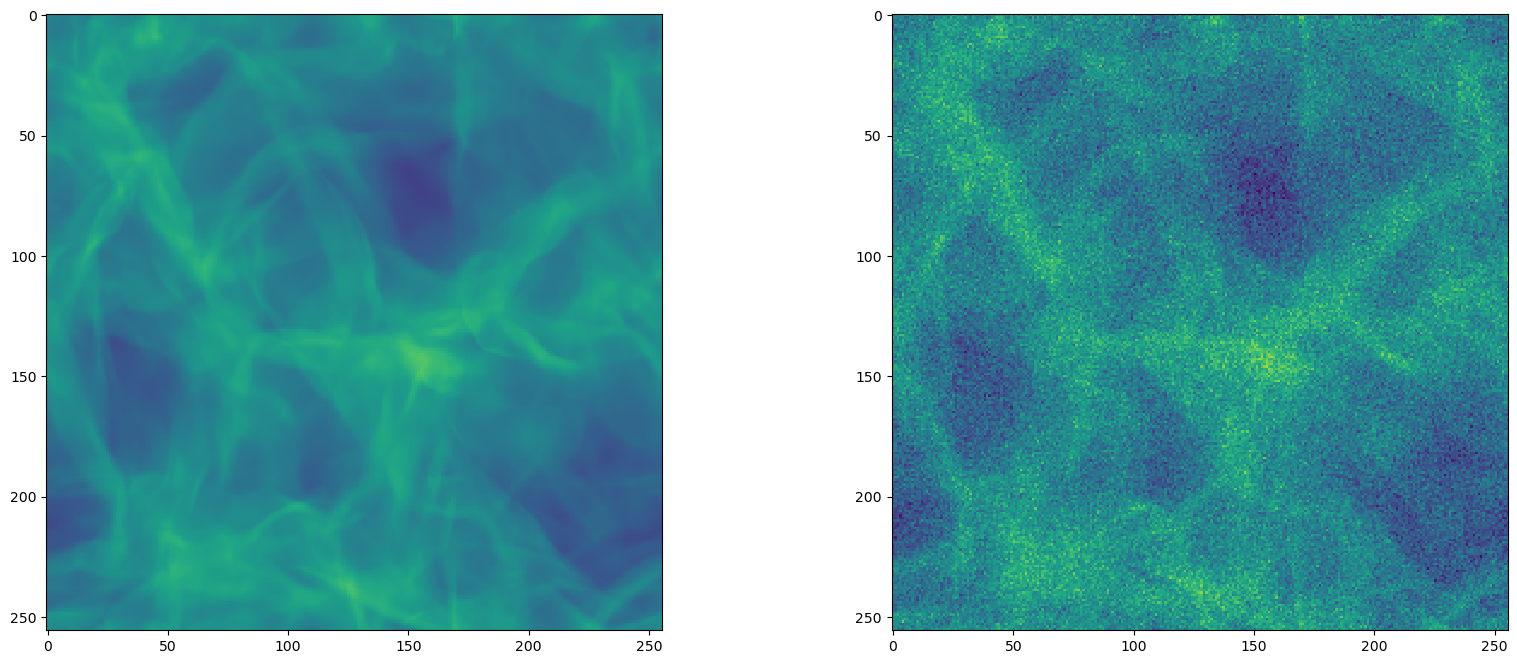

In [17]:
fig, ax= plt.subplots(1,2,figsize=(20,8))
ax[0].imshow(im[0][0],vmin=amin, vmax=amax, interpolation = 'none')
ax[1].imshow(superposition.cpu()[0][0],vmin=amin, vmax=amax, interpolation = 'none')

Wong source separation

In [ ]:
im0,superpos0=im[0],superposition[0]
superpos_test=superpos0.repeat(64,1,1)
superpos_test=superpos_test.unsqueeze(1).to(device)

In [ ]:
s = 0

In [ ]:
model.eval()
with torch.no_grad():
    tot_steps=model.num_timesteps
    with torch.no_grad():
        timesteps=list(range(tot_steps))[::-1]
        #sample1=torch.randn(superpos_test.shape).to(device)
        sample2=torch.randn(superpos_test.shape).to(device)
        for t in timesteps:
            time_tensor = (torch.ones(superpos_test.shape[0], 1)* t).long().to(device)
            #residual1 = model.reverse(sample1, time_tensor)
            residual2 = model.reverse(sample2, time_tensor)

            noise = torch.randn(superpos_test.shape).to(device)
            #c_t1 = model.add_noise(superpos_test,np.sqrt(2)*noise,time_tensor)
            c_t2=model.sqrt_alphas_cumprod[time_tensor[0]]*superpos_test

            #conditional_residual1 = - model.sqrt_one_minus_alphas_cumprod[time_tensor[0]]*(c_t1 - sample1) ## sqrt(1-alpha_barre) score y_t (c_t - x_t)
            conditional_residual2 = - model.sqrt_one_minus_alphas_cumprod[time_tensor[0]]*(c_t2 - sample2) ## sqrt(1-alpha_barre) score y_t (c_t - x_t)
            #sigma = model.betas[time_tensor[0]]
            #sample1 = model.step(residual1+conditional_residual1, time_tensor[0], sample1)
            sample2 = model.step(residual2+conditional_residual2, time_tensor[0], sample2)


In [1]:
fig, ax= plt.subplots(1,3,figsize=(25,8), layout= 'constrained')
ax[0].imshow(im[0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Baseline')
#ax[1].imshow(sample1[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].imshow(sample2[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Separation method 2')
ax[2].imshow(superposition[0][0].detach().cpu(),vmin=amin, vmax=amax, interpolation='non')
ax[2].title.set_text('Superposed')

fig.suptitle('Method 2')

NameError: name 'plt' is not defined

In [555]:
a=np.linspace(0, np.pi, 100)

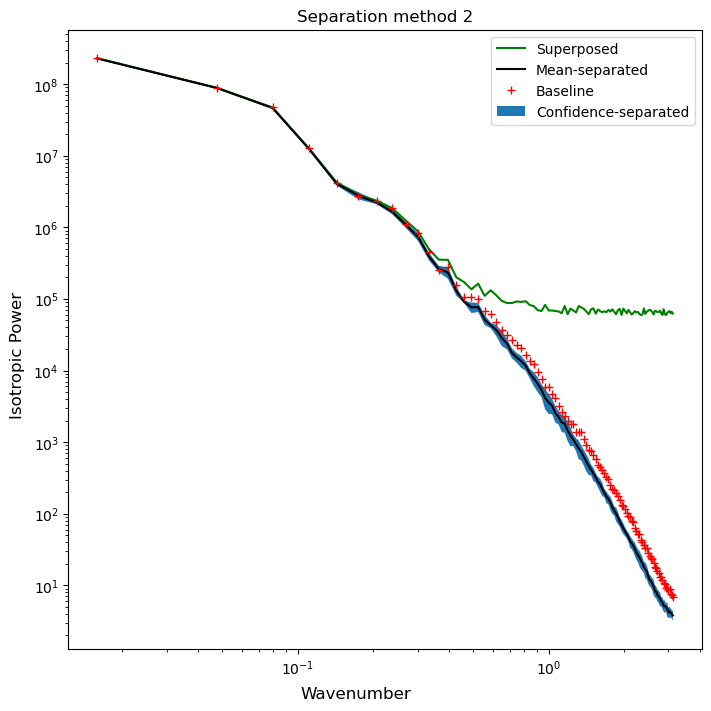

In [556]:
#a,b1,c = power_spectrum_iso(sample1[0][0].detach().cpu().numpy(),bins=np.linspace(0, np.pi, 100))
_, b2, _ = power_spectrum_iso(sample2[0][0].detach().cpu().numpy(),bins=a)
_, b0, _ = power_spectrum_iso(im[0][0],bins=a)
_, b3, _ = power_spectrum_iso(superposition[0][0].detach().cpu(), bins=a)
#plot_ps(a,[ b2,b0, b3], labels=['separated1', 'separated2','original', 'superposition'],show=True)
#power_spectra1=np.concatenate([power_spectrum_iso(sample1[i][0].detach().cpu(),bins=a)[1].reshape(1,100) for i in range(64)],axis=0)
power_spectra2=np.concatenate([power_spectrum_iso(sample2[i][0].detach().cpu(),bins=a)[1].reshape(1,100) for i in range(8)],axis=0)
bins_centers = (a[:-1] + a[1:])/2
    
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')
#mean1,std1=np.mean(power_spectra1,axis=0)[:99],np.std(power_spectra1,axis=0)[:99]
mean2,std2=np.mean(power_spectra2,axis=0)[:99],np.std(power_spectra2,axis=0)[:99]

# ax.plot(bins_centers,b3[:99],'g')
# ax.plot(bins_centers,mean1,'-k')
# ax.plot(bins_centers,b0[:99],'+r')
# ax.fill_between(bins_centers,mean1+1.96*std1,mean1-1.96*std1)

# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.title.set_text('Separation method 1')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')

ax.plot(bins_centers,b3[:99],'g', label = 'Superposed')
ax.plot(bins_centers,mean2,'-k',label = 'Mean-separated')
ax.plot(bins_centers,b0[:99],'+r',label = 'Baseline')
ax.fill_between(bins_centers,mean2+1.96*std2,mean2-1.96*std2,label = 'Confidence-separated')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.title.set_text('Separation method 2')

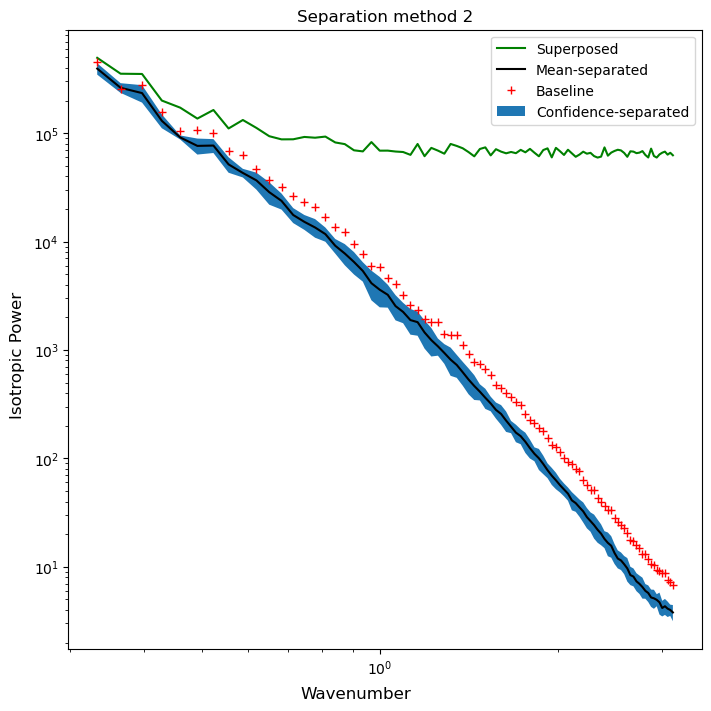

In [557]:
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')

# ax.plot(bins_centers[10:],b3[10:99],'g')
# ax.plot(bins_centers[10:],mean1[10:],'-k')
# ax.plot(bins_centers[10:],b0[10:99],'+r')
# ax.fill_between(bins_centers[10:],(mean1+1.96*std1)[10:],(mean1-1.96*std1)[10:])

# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.title.set_text('Separation method 1')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')

ax.plot(bins_centers[10:],b3[10:99],'g', label = 'Superposed')
ax.plot(bins_centers[10:],mean2[10:],'-k', label = 'Mean-separated')
ax.plot(bins_centers[10:],b0[10:99],'+r', label = 'Baseline')
ax.fill_between(bins_centers[10:],(mean2+1.96*std2)[10:],(mean2-1.96*std2)[10:], label = 'Confidence-separated')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.title.set_text('Separation method 2')

Text(0.5, 0.01, 'Wavenumber')

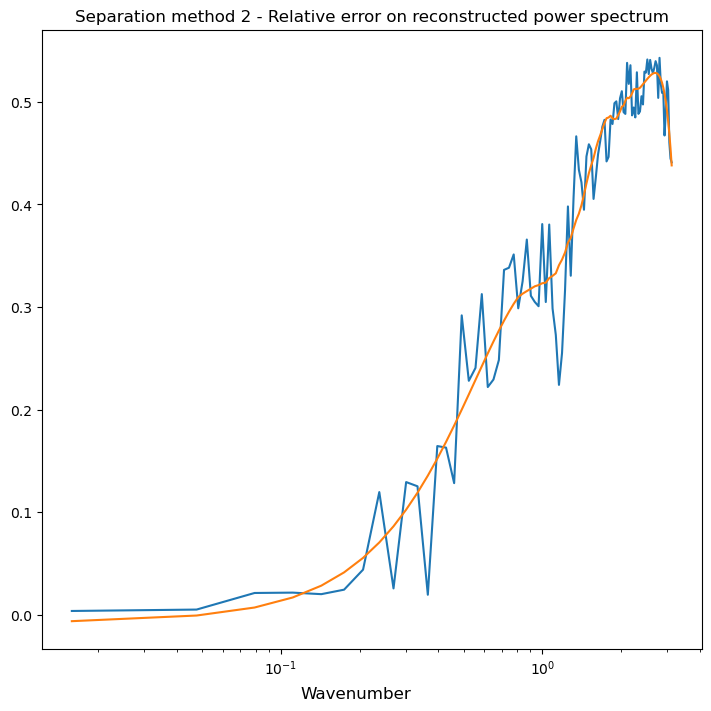

In [558]:
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')
ax.plot(bins_centers, np.abs(b0[:99]-mean2)/b0[:99])
ax.plot(bins_centers, savgol_filter(np.abs(b0[:99]-mean2)/b0[:99], 50, 4))
ax.set_xscale('log')
ax.title.set_text('Separation method 2 - Relative error on reconstructed power spectrum')
fig.supxlabel('Wavenumber')

**Slower version of last one?**

Useless, not working

In [559]:
eta = 0.2 
n_eta = 5

In [560]:
model.eval()
tot_steps=0*model.num_timesteps ## MODIFIED
with torch.no_grad():
    timesteps=list(range(tot_steps))[::-1]
    #sample1=torch.randn(superpos_test.shape).to(device)
    sample2=torch.randn(superpos_test.shape).to(device)
    for t in timesteps:
        for idx in range(n_eta):
            time_tensor = (torch.ones(superpos_test.shape[0], 1)* t).long().to(device)
            #residual1 = model.reverse(sample1, time_tensor)
            residual2 = model.reverse(sample2, time_tensor)

            #noise = torch.randn(superpos_test.shape).to(device)
            #c_t1 = model.add_noise(superpos_test,np.sqrt(2)*noise,time_tensor)
            c_t2=model.sqrt_alphas_cumprod[time_tensor[0]]*superpos_test

            #conditional_residual1 = - model.sqrt_one_minus_alphas_cumprod[time_tensor[0]]*(c_t1 - sample1) ## sqrt(1-alpha_barre) score y_t (c_t - x_t)
            conditional_residual2 = - model.sqrt_one_minus_alphas_cumprod[time_tensor[0]]*(c_t2 - sample2) ## sqrt(1-alpha_barre) score y_t (c_t - x_t)
            #sigma = model.betas[time_tensor[0]]
            #sample1 = model.slower_step(residual1+conditional_residual1, time_tensor[0], sample1, eta=eta)
            sample2 = model.slower_step(residual2+conditional_residual2, time_tensor[0], sample2, eta=eta)

In [561]:
a,b1,c = power_spectrum_iso(sample1[0][0].detach().cpu().numpy(),bins=np.linspace(0, np.pi, 100))
_, b2, _ = power_spectrum_iso(sample2[0][0].detach().cpu().numpy(),bins=a)
_, b0, _ = power_spectrum_iso(im[0][0],bins=a)
_, b3, _ = power_spectrum_iso(superposition[0][0].detach().cpu(), bins=a)
plot_ps(a,[b1, b2,b0, b3], labels=['separated1', 'separated2','original', 'superposition'],show=True)
power_spectra1=np.concatenate([power_spectrum_iso(sample1[i][0].detach().cpu(),bins=a)[1].reshape(1,100) for i in range(64)],axis=0)
power_spectra2=np.concatenate([power_spectrum_iso(sample2[i][0].detach().cpu(),bins=a)[1].reshape(1,100) for i in range(64)],axis=0)
bins_centers = (a[:-1] + a[1:])/2
    
fig, ax = plt.subplots(1, 2,figsize=(14,7), layout='constrained')
mean1,std1=np.mean(power_spectra1,axis=0)[:99],np.std(power_spectra1,axis=0)[:99]
mean2,std2=np.mean(power_spectra2,axis=0)[:99],np.std(power_spectra2,axis=0)[:99]

ax[0].plot(bins_centers,b3[:99],'g')
ax[0].plot(bins_centers,mean1,'-k')
ax[0].plot(bins_centers,b0[:99],'+r')
ax[0].fill_between(bins_centers,mean1+1.96*std1,mean1-1.96*std1)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].title.set_text('Separation method 1')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')

ax[1].plot(bins_centers,b3[:99],'g')
ax[1].plot(bins_centers,mean2,'-k')
ax[1].plot(bins_centers,b0[:99],'+r')
ax[1].fill_between(bins_centers,mean2+1.96*std2,mean2-1.96*std2)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].title.set_text('Separation method 2')

NameError: name 'sample1' is not defined

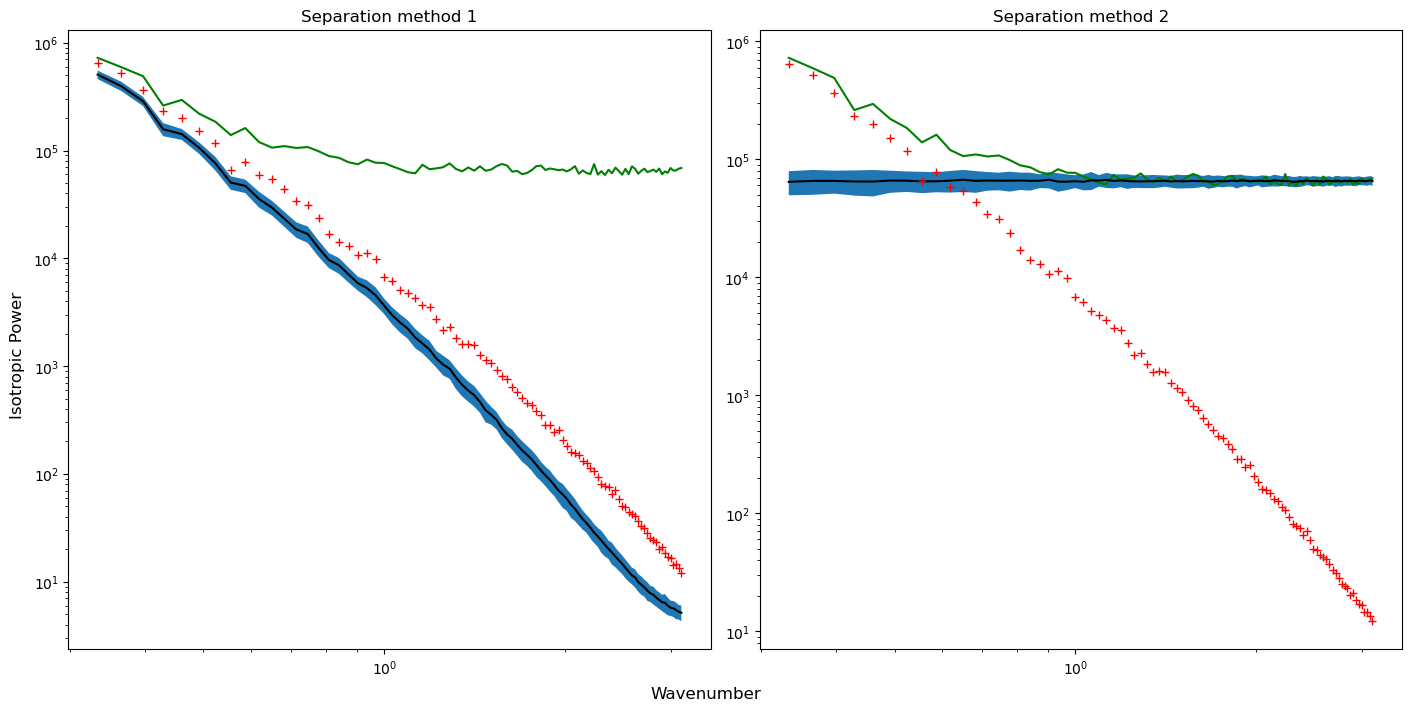

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(14,7), layout='constrained')

ax[0].plot(bins_centers[10:],b3[10:99],'g')
ax[0].plot(bins_centers[10:],mean1[10:],'-k')
ax[0].plot(bins_centers[10:],b0[10:99],'+r')
ax[0].fill_between(bins_centers[10:],(mean1+1.96*std1)[10:],(mean1-1.96*std1)[10:])

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].title.set_text('Separation method 1')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')

ax[1].plot(bins_centers[10:],b3[10:99],'g')
ax[1].plot(bins_centers[10:],mean2[10:],'-k')
ax[1].plot(bins_centers[10:],b0[10:99],'+r')
ax[1].fill_between(bins_centers[10:],(mean2+1.96*std2)[10:],(mean2-1.96*std2)[10:])

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].title.set_text('Separation method 2')

Right?

In [ ]:
tot_steps=model.num_timesteps
with torch.no_grad():
    timesteps=list(range(tot_steps))[::-1]
    samplex=torch.randn_like(superpos_test).to(device) # N(0,1)
    sampleeps=torch.randn_like(superpos_test).to(device)

    for t in timesteps:
        time_tensor = (torch.ones(superpos_test.shape[0], 1)* t).long().to(device)
        
        residualx = model.reverse(samplex, time_tensor)
        
        residualeps =  model.sqrt_one_minus_alphas_cumprod[time_tensor[0]]*(sampleeps)

        conditional_residual = - 2*(model.sqrt_one_minus_alphas_cumprod[time_tensor[0]])**-1*(model.sqrt_alphas_cumprod[time_tensor[0]] * superpos_test - (sampleeps + samplex)) ## Manifold constraint

        samplex = model.step(residualx+conditional_residual, time_tensor[0], samplex)
        sampleeps = model.step(residualeps + conditional_residual, time_tensor[0], sampleeps)

KeyboardInterrupt: 

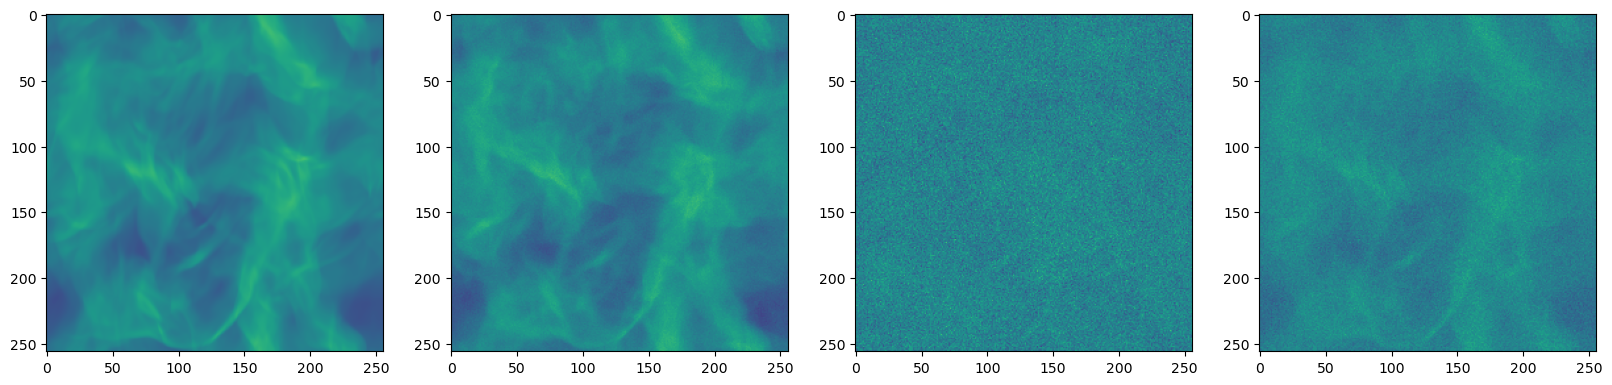

In [ ]:
fig, ax= plt.subplots(1,4,figsize=(20,8))
ax[0].imshow(im[0][0],vmin=amin, vmax=amax)
ax[1].imshow(samplex[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[2].imshow(sampleeps[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[3].imshow(superposition[0][0].detach().cpu(),vmin=2*amin, vmax=2*amax)

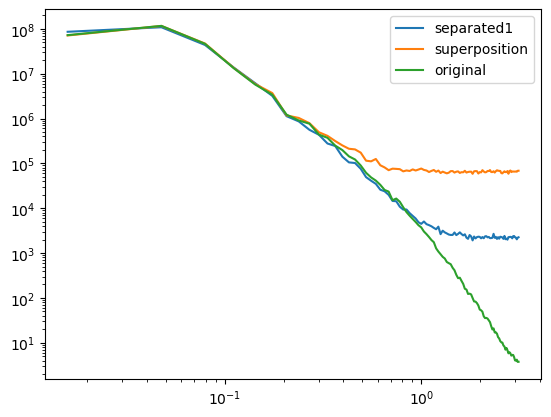

In [ ]:
a , b1, _ = power_spectrum_iso(samplex[0][0].detach().cpu().numpy(),bins=a)
_ , b2, _ = power_spectrum_iso(superposition[0][0].detach().cpu().numpy(), bins=a)
_ , b3, _ = power_spectrum_iso(im[0][0],bins=a)
plot_ps(a,[b1,b2,b3], labels=['separated1','superposition','original'],show=True)

Slower version of last one

In [ ]:
eta = 0.2 
n_eta = 5

In [ ]:
tot_steps=model.num_timesteps
with torch.no_grad():
    timesteps=list(range(tot_steps))[::-1]
    samplex=torch.randn_like(superpos_test).to(device) # N(0,1)
    sampleeps=torch.randn_like(superpos_test).to(device)

    for t in timesteps:
        for idx in range(n_eta):
            time_tensor = (torch.ones(superpos_test.shape[0], 1)* t).long().to(device)
            
            residualx = model.reverse(samplex, time_tensor)
            
            residualeps =  model.sqrt_one_minus_alphas_cumprod[time_tensor[0]]*(sampleeps)

            conditional_residual = - 2*(model.sqrt_one_minus_alphas_cumprod[time_tensor[0]])**-1*(model.sqrt_alphas_cumprod[time_tensor[0]] * superpos_test - (sampleeps + samplex)) ## Manifold constraint

            samplex = model.slower_step(residualx+conditional_residual, time_tensor[0], samplex, eta=eta)
            sampleeps = model.slower_step(residualeps + conditional_residual, time_tensor[0], sampleeps, eta=eta)

Text(0.5, 0.01, 'Wavenumber')

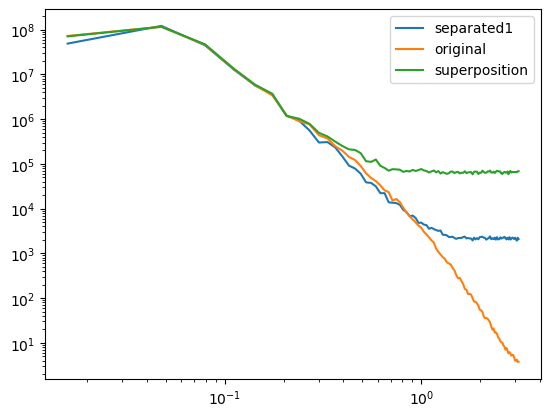

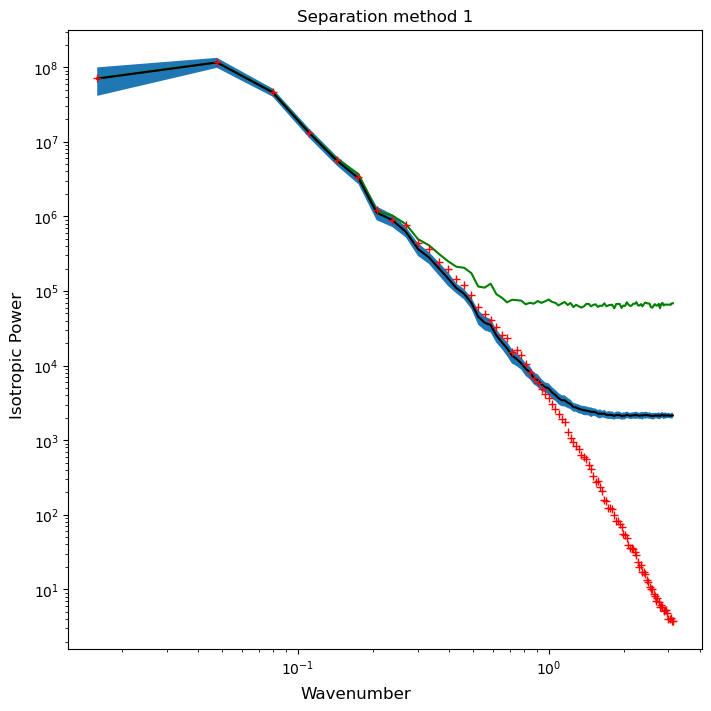

In [ ]:
a,b1,c = power_spectrum_iso(samplex[0][0].detach().cpu().numpy(),bins=np.linspace(0, np.pi, 100))
_, b0, _ = power_spectrum_iso(im[0][0],bins=a)
_, b3, _ = power_spectrum_iso(superposition[0][0].detach().cpu(), bins=a)
plot_ps(a,[b1,b0, b3], labels=['separated1','original', 'superposition'],show=True)
power_spectra1=np.concatenate([power_spectrum_iso(samplex[i][0].detach().cpu(),bins=a)[1].reshape(1,100) for i in range(64)],axis=0)
bins_centers = (a[:-1] + a[1:])/2
    
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')
mean1,std1=np.mean(power_spectra1,axis=0)[:99],np.std(power_spectra1,axis=0)[:99]
mean2,std2=np.mean(power_spectra2,axis=0)[:99],np.std(power_spectra2,axis=0)[:99]

ax.plot(bins_centers,b3[:99],'g')
ax.plot(bins_centers,mean1,'-k')
ax.plot(bins_centers,b0[:99],'+r')
ax.fill_between(bins_centers,mean1+1.96*std1,mean1-1.96*std1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.title.set_text('Separation method 1')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')

In [ ]:
# superposition_2 = superposition_2.to(device)
# model.eval()
# tot_steps=model.num_timesteps
# with torch.no_grad():
#     timesteps=list(range(tot_steps))[::-1]
#     sample=torch.randn(im.shape).to(device)
#     for t in timesteps:
#         time_tensor = (torch.ones(im.shape[0], 1)* t).long().to(device)
#         residual = model.reverse(sample, time_tensor)

#         noise = torch.randn(superposition.shape).to(device)
#         c_t = model.add_noise(superposition_2,np.sqrt(2)*noise,time_tensor)

#         conditional_residual = model.reverse(c_t-sample,time_tensor) ## sqrt(1-alpha_barre) score y_t (c_t - x_t)

#         sample = model.step(residual-conditional_residual, time_tensor[0], sample)

# fig, ax= plt.subplots(1,4,figsize=(20,8))
# ax[0].imshow(im[0][0],vmin=amin, vmax=amax)
# ax[1].imshow(torch.roll(im,1,0)[0][0],vmin=amin, vmax=amax)
# ax[2].imshow(sample[0][0].detach().cpu(),vmin=amin, vmax=amax)
# ax[3].imshow(superposition_2[0][0].detach().cpu(),vmin=2*amin, vmax=2*amax)

Correct source separation?

In [ ]:
dW1=torch.randn((model.num_timesteps,64,1,256,256))
dW2=torch.randn((model.num_timesteps,64,1,256,256))
xi_tilde_1=torch.sqrt(model.betas.cpu()).reshape(-1,1,1,1,1)/model.sqrt_alphas_cumprod.cpu().reshape(-1,1,1,1,1)*dW1
sigma_i_1=torch.cumsum(xi_tilde_1, dim=0)
xi_tilde_2=torch.sqrt(model.betas.cpu()).reshape(-1,1,1,1,1)/model.sqrt_alphas_cumprod.cpu().reshape(-1,1,1,1,1)*dW2
sigma_i_2=torch.cumsum(xi_tilde_2, dim=0)

KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    model.eval()
    tot_steps=model.num_timesteps
    with torch.no_grad():
        timesteps=list(range(tot_steps))[::-1]
        sample1=model.sqrt_alphas_cumprod[-1]*sigma_i_1[-1].to(device) # N(0,1)
        for t in timesteps:
            time_tensor = (torch.ones(superpos_test.shape[0], 1)* t).long().to(device)
            residual1 = model.reverse(sample1, time_tensor)

            c_t=model.sqrt_alphas_cumprod[time_tensor[0]]*(superpos_test+sigma_i_1[t].to(device)+sigma_i_2[t].to(device))

            conditional_residual1 = - model.sqrt_one_minus_alphas_cumprod[time_tensor[0]]*(c_t - sample1) ## sqrt(1-alpha_barre) score y_t (c_t - x_t)
            sigma = model.betas[time_tensor[0]]

            sample1 = model.step(residual1+sigma*conditional_residual1, time_tensor[0], sample1)##

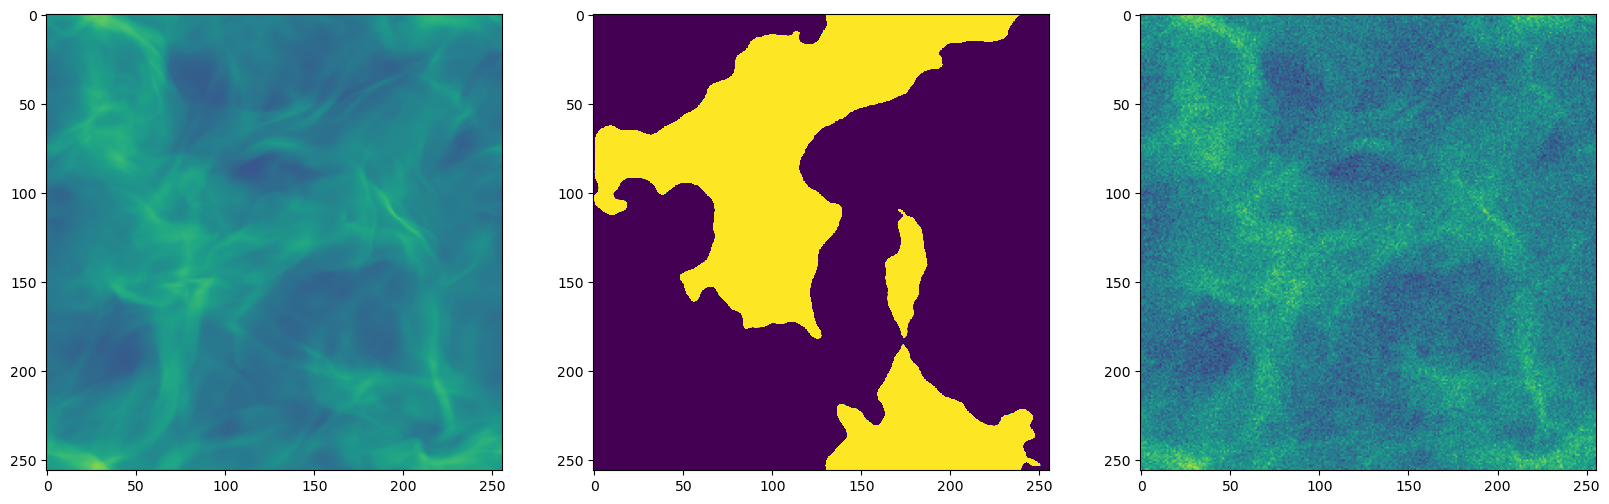

In [ ]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(im[0][0],vmin=amin, vmax=amax)
ax[1].imshow(sample1[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[2].imshow(superposition[0][0].detach().cpu(),vmin=amin, vmax=amax)

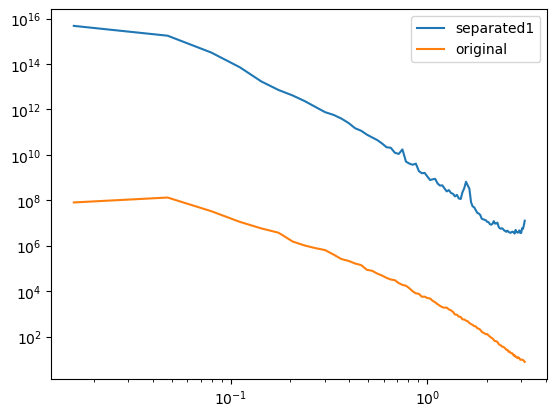

In [ ]:
a, b1, _ = power_spectrum_iso(sample1[0][0].detach().cpu().numpy(),bins=a)
_, b3, _ = power_spectrum_iso(im[0][0],bins=a)
plot_ps(a,[b1,b3], labels=['separated1','original'],show=True)